In [17]:
import tensorflow as tf
import seaborn as sns    
import re
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import lime.lime_tabular
import lime
import keras.preprocessing.text
import keras
import datetime 
import copy
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from random import *
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional,SpatialDropout1D, MaxPooling1D
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras import backend as K
%matplotlib inline
plt.rc('font', family='NanumBarunGothicOTF')
mpl.rcParams['axes.unicode_minus'] = False

In [11]:
early_stopping = EarlyStopping(monitor='val_loss',patience=100,restore_best_weights=True)

### - 띄워쓰기 없는 부분 추가 : 1회만

In [3]:
# def inplace_change(filename, old_string, new_string):
#     with open(filename, 'r') as f:
#         print(f)
#         s = f.read()
#         s = re.sub(old_string, new_string, s)
        
#     with open(filename, 'w+') as f:
#         #print('Changing "{old_string}" to "{new_string}" in {filename}'.format(**locals()))
#         print(s)
#         f.write(s)    
        
# directory = "./위성/VIS/"
# f_list = os.listdir(directory)

# f_list.sort()
# temp = pd.DataFrame()

# for f in f_list:
#     #print(f)
#     inplace_change(directory + f,'[^\S\r\n]*-', ' -')

## 날짜 정보 추출

In [18]:
directory = "./위성/CDOM/"
f_list = os.listdir(directory)

date_list = []
for f in f_list:
    date_list.append(f[3:13])

In [13]:
date_list.sort()

## 오차함수 정의 : RMSE 사용

In [19]:
from keras.losses import mean_squared_error

def RMSE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
def MAE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 
import tensorflow as tf
def RMSLE(y, y0):
    return K.sqrt(K.mean(K.square(tf.log1p(y) - tf.log1p(y0))))

## 수치모형 데이터 로드

In [122]:
directory = "./수치모형/temperature/"
vname = "temperature_"
temp_arr = []
for d in date_list:
    temp = pd.read_csv(directory + vname + str(d) +".csv",header=None,index_col=0)
    temp = temp.reset_index(drop=True)
    temp_arr.append(np.array(temp).tolist())  
    
directory = "./수치모형/salinity/"
vname = "salinity_"
salinity_arr = []
for d in date_list:
    salinity = pd.read_csv(directory + vname + str(d) +".csv",header=None,index_col=0)
    salinity = salinity.reset_index(drop=True)
    salinity_arr.append(np.array(salinity).tolist())  
    
directory = "./수치모형/velocity/"
vname = "velocity_"
velocity_arr = []
for d in date_list:
    velocity = pd.read_csv(directory + vname + str(d) +".csv",header=None,index_col=0)
    velocity = velocity.reset_index(drop=True)
    velocity_arr.append(np.array(velocity).tolist())  
    
directory = "./수치모형/waterlevel/"
vname = "waterlevel_"
waterlevel_arr = []
for d in date_list:
    waterlevel = pd.read_csv(directory + vname + str(d) +".csv",header=None,index_col=0)
    waterlevel = waterlevel.reset_index(drop=True)
    waterlevel_arr.append(np.array(waterlevel).tolist())  

## 위성 데이터 로드

In [121]:
directory = "./위성/CDOM/"
f_list = os.listdir(directory)

f_list.sort()
temp = pd.DataFrame()
cdom_result_arr = []

for idx,f in enumerate(f_list):
    #print(f)
    temp = pd.read_csv(directory + f, sep='\s+', header=None)
    cdom_result_arr.append(np.array(temp).tolist())   
    
directory = "./위성/CHLA/"
f_list = os.listdir(directory)

f_list.sort()
temp = pd.DataFrame()
chla_result_arr = []

for idx,f in enumerate(f_list):
    #print(f)
    temp = pd.read_csv(directory + f, sep='\s+', header=None)
    chla_result_arr.append(np.array(temp).tolist())   
    
    
directory = "./위성/TSS/"
f_list = os.listdir(directory)

f_list.sort()
temp = pd.DataFrame()
tss_result_arr = []

for idx,f in enumerate(f_list):
    #print(f)
    temp = pd.read_csv(directory + f, sep='\s+', header=None)
    tss_result_arr.append(np.array(temp).tolist())   
    
    
directory = "./위성/VIS/"
f_list = os.listdir(directory)

f_list.sort()
temp = pd.DataFrame()
vis_result_arr = []

for idx,f in enumerate(f_list):
    #print(f)
    temp = pd.read_csv(directory + f, sep='\s+', header=None)
    vis_result_arr.append(np.array(temp).tolist())   

## 데이터 배열형태로 변환

In [123]:
cdom_result_arr = np.array(cdom_result_arr)
chla_result_arr = np.array(chla_result_arr)
tss_result_arr = np.array(tss_result_arr)
vis_result_arr = np.array(vis_result_arr)
temp_arr = np.array(temp_arr)
salinity_arr = np.array(salinity_arr)
waterlevel_arr = np.array(waterlevel_arr)
velocity_arr = np.array(velocity_arr)

In [23]:
n = cdom_result_arr.shape[0]
w = cdom_result_arr.shape[1]
h = cdom_result_arr.shape[2]
c = 1

## 데이터 차원수 체크

In [24]:
print(cdom_result_arr.shape)
print(tss_result_arr.shape)
print(vis_result_arr.shape)

(1331, 48, 27)
(1331, 48, 27)
(1331, 48, 27)


## 데이터 결합

In [25]:
# Best 경우

cdom_result_arr= cdom_result_arr.reshape(n,w,h,c)
tss_result_arr= tss_result_arr.reshape(n,w,h,c)
vis_result_arr = vis_result_arr.reshape(n,w,h,c)
salinity_arr = salinity_arr.reshape(n,w,h,c)
waterlevel_arr = waterlevel_arr.reshape(n,w,h,c)
temp_arr = temp_arr.reshape(n,w,h,c)
velocity_arr = velocity_arr.reshape(n,w,h,c)

chla_result_arr= chla_result_arr.reshape(n,w,h,c)
print(cdom_result_arr.shape)

(1331, 48, 27, 1)


## 저장파일명 지정

In [102]:
fname = "./model/100_ALL"

## 데이터 결합

In [1]:
# # 1개씩 쓸때
#x_all =  vis_result_arr

In [24]:
# # Best 경우

# x_all = np.concatenate((tss_result_arr,salinity_arr),axis=3)
# x_all = np.concatenate((x_all, vis_result_arr),axis=3)

In [26]:
# 전체
x_all = np.concatenate((cdom_result_arr, tss_result_arr),axis=3)
x_all = np.concatenate((x_all, vis_result_arr),axis=3)
x_all = np.concatenate((x_all, salinity_arr),axis=3)
x_all = np.concatenate((x_all, waterlevel_arr),axis=3)
x_all = np.concatenate((x_all, temp_arr),axis=3)
x_all = np.concatenate((x_all, velocity_arr),axis=3)

## 학습 및 테스트 데이터 분할

In [27]:
train_num = 932
val_num = 271

x_train = x_all[0:train_num]
x_val = x_all[train_num:train_num+val_num]
x_test = x_all[train_num+val_num:]

y_all = chla_result_arr
y_train = y_all[0:train_num]
y_val = y_all[train_num:train_num+val_num]
y_test = y_all[train_num+val_num:]

vidx = np.where(y_train[0].flatten() != 0)

In [ ]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

## 이미지 분할

In [28]:
# Training
x_list = []
y_list = []
m = 3
sw = 7
sh = 7


for i in range(0,y_train.shape[0]):
    for j in range(m,y_train.shape[1]-m):
        for k in range(m,y_train.shape[2]-m):
            y_list.append(y_train[i][j][k][0])    
            x_temp = x_train[i]
            x_temp = x_temp[(j-m):(j+m+1),(k-m):(k+m+1)]
            #print(x_temp.shape)
            x_list.append(x_temp)        
            
x_arr = np.array(x_list)
y_arr = np.array(y_list)
#cond = np.logical_and((x_arr_sum != 0), (y_arr != 0))

sub_x_train_arr = x_arr[y_arr != 0]
sub_y_train_arr = y_arr[y_arr != 0]


# Valdation
x_list = []
y_list = []
m = 3
sw = 7
sh = 7


for i in range(0,y_val.shape[0]):
    for j in range(m,y_val.shape[1]-m):
        for k in range(m,y_val.shape[2]-m):
            y_list.append(y_val[i][j][k][0])    
            x_temp = x_val[i]
            x_temp = x_temp[(j-m):(j+m+1),(k-m):(k+m+1)]
            #print(x_temp.shape)
            x_list.append(x_temp)        
            
x_arr = np.array(x_list)
y_arr = np.array(y_list)
#cond = np.logical_and((x_arr_sum != 0), (y_arr != 0))

sub_x_val_arr = x_arr[y_arr != 0]
sub_y_val_arr = y_arr[y_arr != 0]

In [4]:
x_arr

NameError: name 'x_arr' is not defined

In [3]:
import seaborn as sns
sns.heatmap(x_arr[0],vmin=0,vmax=max_val)

NameError: name 'x_arr' is not defined

## 데이터 분포 체크

In [109]:
print(sub_y_train_arr.flatten().std())
print(sub_y_val_arr.flatten().std())
#sub_y_val_arr.flatten().mean())

0.8137888039415646
0.8078505157424286


In [117]:
#from keras import optimizers

# All parameter gradients will be clipped to
# a maximum norm of 1.
#sgd = optimizers.SGD(lr=0.003, clipnorm=1.)
#adam = optimizers.Adam(lr=0.005, clipnorm=0.001)

## 모형학습

In [116]:
# Model2

leaky_relu = tf.nn.leaky_relu

import keras.backend.tensorflow_backend as K
with K.tf.device('/cpu:0'):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation=leaky_relu,input_shape=(sw,sh,7)))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3), activation=leaky_relu))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(32, activation=leaky_relu))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.compile(loss=RMSE, metrics=[RMSE],optimizer='adam')
    
with K.tf.device('/cpu:0'):
    hist = model.fit(sub_x_train_arr,sub_y_train_arr, batch_size=256, epochs=50000,validation_data=[sub_x_val_arr,sub_y_val_arr],callbacks=[early_stopping])

Train on 293580 samples, validate on 85365 samples
Epoch 1/50000
293580/293580 [==============================] - 8s 28us/step - loss: 0.6289 - RMSE: 0.6289 - val_loss: 0.3477 - val_RMSE: 0.3475
Epoch 2/50000
293580/293580 [==============================] - 7s 25us/step - loss: 0.4594 - RMSE: 0.4594 - val_loss: 0.3504 - val_RMSE: 0.3502
Epoch 3/50000
293580/293580 [==============================] - 8s 26us/step - loss: 0.4123 - RMSE: 0.4123 - val_loss: 0.3347 - val_RMSE: 0.3344
Epoch 4/50000
293580/293580 [==============================] - 8s 26us/step - loss: 0.3863 - RMSE: 0.3863 - val_loss: 0.3055 - val_RMSE: 0.3052
Epoch 5/50000
293580/293580 [==============================] - 8s 26us/step - loss: 0.3719 - RMSE: 0.3719 - val_loss: 0.3029 - val_RMSE: 0.3026
Epoch 6/50000
293580/293580 [==============================] - 8s 26us/step - loss: 0.3624 - RMSE: 0.3624 - val_loss: 0.3165 - val_RMSE: 0.3162
Epoch 7/50000
293580/293580 [==============================] - 8s 26us/step - loss: 0

293580/293580 [==============================] - 8s 27us/step - loss: 0.2953 - RMSE: 0.2953 - val_loss: 0.2572 - val_RMSE: 0.2569
Epoch 114/50000
293580/293580 [==============================] - 8s 27us/step - loss: 0.2957 - RMSE: 0.2957 - val_loss: 0.2452 - val_RMSE: 0.2449
Epoch 115/50000
293580/293580 [==============================] - 8s 26us/step - loss: 0.2947 - RMSE: 0.2947 - val_loss: 0.2531 - val_RMSE: 0.2528
Epoch 116/50000
293580/293580 [==============================] - 8s 26us/step - loss: 0.2961 - RMSE: 0.2961 - val_loss: 0.2550 - val_RMSE: 0.2547
Epoch 117/50000
293580/293580 [==============================] - 8s 27us/step - loss: 0.2951 - RMSE: 0.2951 - val_loss: 0.2465 - val_RMSE: 0.2462
Epoch 118/50000
293580/293580 [==============================] - 8s 26us/step - loss: 0.2961 - RMSE: 0.2961 - val_loss: 0.2530 - val_RMSE: 0.2527
Epoch 119/50000
293580/293580 [==============================] - 8s 26us/step - loss: 0.2952 - RMSE: 0.2952 - val_loss: 0.2434 - val_RMSE: 0

293580/293580 [==============================] - 7s 25us/step - loss: 0.2816 - RMSE: 0.2816 - val_loss: 0.2470 - val_RMSE: 0.2467
Epoch 226/50000
293580/293580 [==============================] - 7s 25us/step - loss: 0.2818 - RMSE: 0.2818 - val_loss: 0.2354 - val_RMSE: 0.2352
Epoch 227/50000
293580/293580 [==============================] - 7s 25us/step - loss: 0.2836 - RMSE: 0.2836 - val_loss: 0.2280 - val_RMSE: 0.2278
Epoch 228/50000
293580/293580 [==============================] - 7s 25us/step - loss: 0.2821 - RMSE: 0.2821 - val_loss: 0.2254 - val_RMSE: 0.2252
Epoch 229/50000
293580/293580 [==============================] - 7s 25us/step - loss: 0.2817 - RMSE: 0.2817 - val_loss: 0.2233 - val_RMSE: 0.2230
Epoch 230/50000
293580/293580 [==============================] - 7s 25us/step - loss: 0.2817 - RMSE: 0.2817 - val_loss: 0.2225 - val_RMSE: 0.2222
Epoch 231/50000
293580/293580 [==============================] - 7s 25us/step - loss: 0.2835 - RMSE: 0.2835 - val_loss: 0.2153 - val_RMSE: 0

293580/293580 [==============================] - 7s 24us/step - loss: 0.2744 - RMSE: 0.2744 - val_loss: 0.2188 - val_RMSE: 0.2186
Epoch 338/50000
293580/293580 [==============================] - 7s 25us/step - loss: 0.2735 - RMSE: 0.2735 - val_loss: 0.2187 - val_RMSE: 0.2184
Epoch 339/50000
293580/293580 [==============================] - 7s 25us/step - loss: 0.2760 - RMSE: 0.2760 - val_loss: 0.2151 - val_RMSE: 0.2149
Epoch 340/50000
293580/293580 [==============================] - 7s 24us/step - loss: 0.2738 - RMSE: 0.2738 - val_loss: 0.2186 - val_RMSE: 0.2184
Epoch 341/50000
293580/293580 [==============================] - 7s 24us/step - loss: 0.2748 - RMSE: 0.2748 - val_loss: 0.2346 - val_RMSE: 0.2343
Epoch 342/50000
293580/293580 [==============================] - 8s 26us/step - loss: 0.2756 - RMSE: 0.2756 - val_loss: 0.2077 - val_RMSE: 0.2074
Epoch 343/50000
293580/293580 [==============================] - 8s 29us/step - loss: 0.2740 - RMSE: 0.2740 - val_loss: 0.2146 - val_RMSE: 0

293580/293580 [==============================] - 7s 25us/step - loss: 0.2702 - RMSE: 0.2702 - val_loss: 0.2070 - val_RMSE: 0.2068
Epoch 450/50000
293580/293580 [==============================] - 7s 25us/step - loss: 0.2701 - RMSE: 0.2700 - val_loss: 0.2066 - val_RMSE: 0.2064
Epoch 451/50000
293580/293580 [==============================] - 7s 25us/step - loss: 0.2691 - RMSE: 0.2691 - val_loss: 0.2327 - val_RMSE: 0.2325
Epoch 452/50000
293580/293580 [==============================] - 7s 24us/step - loss: 0.2699 - RMSE: 0.2699 - val_loss: 0.2026 - val_RMSE: 0.2024
Epoch 453/50000
293580/293580 [==============================] - 7s 24us/step - loss: 0.2706 - RMSE: 0.2706 - val_loss: 0.2085 - val_RMSE: 0.2083
Epoch 454/50000
293580/293580 [==============================] - 7s 25us/step - loss: 0.2697 - RMSE: 0.2697 - val_loss: 0.1966 - val_RMSE: 0.1964
Epoch 455/50000
293580/293580 [==============================] - 7s 24us/step - loss: 0.2690 - RMSE: 0.2690 - val_loss: 0.2116 - val_RMSE: 0

293580/293580 [==============================] - 7s 25us/step - loss: 0.2664 - RMSE: 0.2664 - val_loss: 0.1960 - val_RMSE: 0.1958
Epoch 562/50000
293580/293580 [==============================] - 7s 25us/step - loss: 0.2665 - RMSE: 0.2665 - val_loss: 0.2031 - val_RMSE: 0.2029
Epoch 563/50000
293580/293580 [==============================] - 7s 24us/step - loss: 0.2650 - RMSE: 0.2650 - val_loss: 0.2017 - val_RMSE: 0.2015
Epoch 564/50000
293580/293580 [==============================] - 7s 25us/step - loss: 0.2665 - RMSE: 0.2665 - val_loss: 0.1938 - val_RMSE: 0.1936
Epoch 565/50000
293580/293580 [==============================] - 7s 26us/step - loss: 0.2673 - RMSE: 0.2673 - val_loss: 0.2046 - val_RMSE: 0.2044
Epoch 566/50000
293580/293580 [==============================] - 8s 26us/step - loss: 0.2669 - RMSE: 0.2669 - val_loss: 0.2255 - val_RMSE: 0.2253
Epoch 567/50000
293580/293580 [==============================] - 7s 25us/step - loss: 0.2675 - RMSE: 0.2675 - val_loss: 0.2263 - val_RMSE: 0

## 히스토리 저장

In [118]:
hist_df = pd.DataFrame(hist.history).sort_values(['val_loss'])
hist_df.to_excel(fname + ".xlsx")

/usr/local/lib/python3.6/dist-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '0.9.8' or newer of 'xlsxwriter' (version '0.7.3' currently installed).
  warnings.warn(msg, UserWarning)


In [119]:
hist_df

,val_loss,val_RMSE,loss,RMSE
481,0.190978,0.190763,0.268619,0.268625
537,0.190993,0.190790,0.268932,0.268928
568,0.191382,0.191197,0.267198,0.267191
483,0.191390,0.191183,0.268219,0.268210
546,0.191853,0.191656,0.268303,0.268300
...,...,...,...,...
5,0.316526,0.316187,0.362370,0.362370
7,0.320993,0.320680,0.349759,0.349755
2,0.334689,0.334383,0.412334,0.412343
0,0.347680,0.347470,0.628892,0.628874


## 모델 저장

In [120]:
model.save(fname + ".h5")

## 모델 로드

In [115]:
from keras.models import load_model
import keras.backend.tensorflow_backend as K
with K.tf.device('/cpu:0'):
    model = load_model(fname+".h5",custom_objects={'leaky_relu': tf.nn.leaky_relu,'RMSE': RMSE})

OSError: Unable to open file (unable to open file: name = './model/100_ALL.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [44]:
# import matplotlib.pyplot as plt

# fig, loss_ax = plt.subplots()
# acc_ax = loss_ax.twinx()

# loss_ax.plot(hist.history['loss'][1:], 'y', label='train loss')
# loss_ax.plot(hist.history['val_loss'][1:], 'r', label='val loss')
# loss_ax.set_xlabel('epoch')
# loss_ax.set_ylabel('loss')
# loss_ax.legend(loc='upper left')

# plt.show()

## 성능 테스트

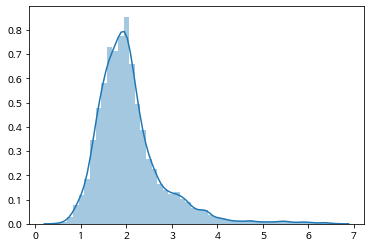

In [30]:
x_test2 = x_test
y_test2 = y_test
sns.distplot(y_test2[y_test2 !=0])

In [ ]:
len(y_test2[y_test2 !=0])

In [ ]:
np.std(y_test2[y_test2 !=0])

In [124]:
rmse_list = []
n = 0
for n in range(0,128):
    x_test = x_test2[n:(n+1)]
    y_test = y_test2[n:(n+1)]


    x_test_list = []
    y_test_list = []

    for i in range(0,y_test.shape[0]):
        for j in range(m,y_test.shape[1]-m):
            for k in range(m,y_test.shape[2]-m):
                y_test_list.append(y_test[i][j][k][0])    
                x_temp = x_test[i]
                x_temp = x_temp[(j-m):(j+m+1),(k-m):(k+m+1)]
                #print(x_temp.shape)
                x_test_list.append(x_temp)        

    x_test_arr = np.array(x_test_list)
    y_test_arr = np.array(y_test_list)
    #cond = np.logical_wand((x_arr_sum != 0), (y_arr != 0))

    sub_x_test_arr = x_test_arr[y_test_arr != 0]
    sub_y_test_arr = y_test_arr[y_test_arr != 0]


    vidx = np.where(y_test_arr != 0)[0].tolist()

    pred = model.predict(sub_x_test_arr)
    rmse = mean_squared_error(sub_y_test_arr, pred)**0.5
    rmse_list.append(rmse)

#print(np.mean(rmse_list))
rmse_df = pd.DataFrame(rmse_list)

rmse_df.to_excel(fname+"_RMSE.xlsx")

/usr/local/lib/python3.6/dist-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '0.9.8' or newer of 'xlsxwriter' (version '0.7.3' currently installed).
  warnings.warn(msg, UserWarning)


In [ ]:
a = pd.read_excel(fname+"_RMSE.xlsx")

In [ ]:
a[0]

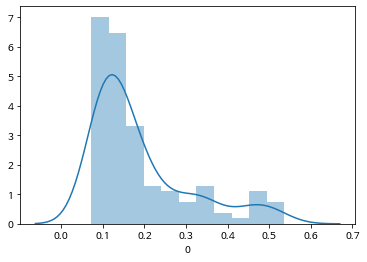

In [78]:
sns.distplot(a[0])

In [44]:
np.mean(rmse_list)

0.18167904301097318

## 한 데이터씩 살피기

In [31]:
n = 67
x_test = x_test2[n:(n+1)]
y_test = y_test2[n:(n+1)]

x_test_list = []
y_test_list = []

for i in range(0,y_test.shape[0]):
    for j in range(m,y_test.shape[1]-m):
        for k in range(m,y_test.shape[2]-m):
            y_test_list.append(y_test[i][j][k][0])    
            x_temp = x_test[i]
            x_temp = x_temp[(j-m):(j+m+1),(k-m):(k+m+1)]
            print(x_temp.shape)
            x_test_list.append(x_temp)        
            
x_test_arr = np.array(x_test_list)
y_test_arr = np.array(y_test_list)

(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


In [29]:
n = 67
x_test = x_test2[n:(n+1)]
y_test = y_test2[n:(n+1)]

x_test_list = []
y_test_list = []

for i in range(0,y_test.shape[0]):
    for j in range(m,y_test.shape[1]-m):
        for k in range(m,y_test.shape[2]-m):
            y_test_list.append(y_test[i][j][k][0])    
            x_temp = x_test[i]
            x_temp = x_temp[(j-m):(j+m+1),(k-m):(k+m+1)]
            print(x_temp.shape)
            x_test_list.append(x_temp)        
            
x_test_arr = np.array(x_test_list)
y_test_arr = np.array(y_test_list)
#cond = np.logical_wand((x_arr_sum != 0), (y_arr != 0))

sub_x_test_arr = x_test_arr[y_test_arr != 0]
sub_y_test_arr = y_test_arr[y_test_arr != 0]

vidx = np.where(y_test_arr != 0)[0].tolist()

from sklearn.metrics import mean_squared_error
pred = model.predict(sub_x_test_arr)
rmse = mean_squared_error(sub_y_test_arr, pred)**0.5

mw = w - 2*m
mh = h - 2*m

result = np.zeros(len(y_test_arr))
result[vidx] = pred.flatten()
result = result.reshape([mw,mh])
result_re = np.pad(result,3)

y_test_re = y_test.flatten().reshape(w,h)

# # 파일 저장
# pd.DataFrame(y_test_re).to_csv("./"+fname+"_original.csv")
# pd.DataFrame(result_re).to_csv("./"+fname+"_pred.csv")

NameError: name 'x_test2' is not defined

In [299]:
max_val = max(y_test_re.flatten())

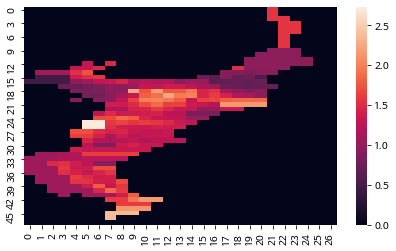

In [295]:
sns.heatmap(y_test_re,vmax=max_val)

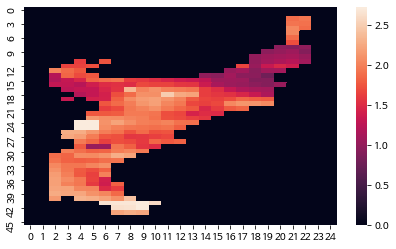

In [304]:
sns.heatmap(result_re,vmin=0,vmax=max_val)

In [66]:
sns.distplot(rmse_list)

NameError: name 'rmse_list' is not defined

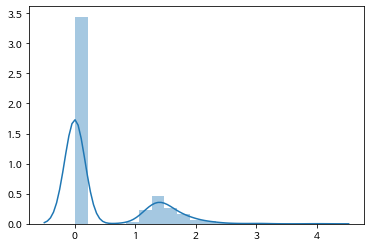

In [50]:
sns.distplot(y_test_re.flatten())

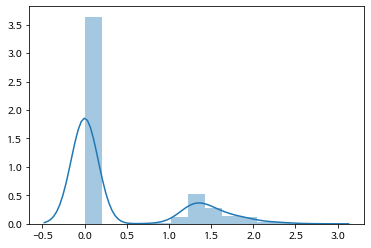

In [51]:
sns.distplot(result_re.flatten())

## R-Sqaure Plot 그리기

In [170]:
result_re.shape
y_test_re.shape

(48, 27)

In [258]:
y_true = y_test_re.flatten()

In [167]:
y_true

array([0., 0., 0., ..., 0., 0., 0.])

In [316]:
y_true = y_test_re.flatten()
y_pred = result_re.flatten()

y_true = y_true[y_pred != 0]
y_pred = y_pred[y_pred != 0]


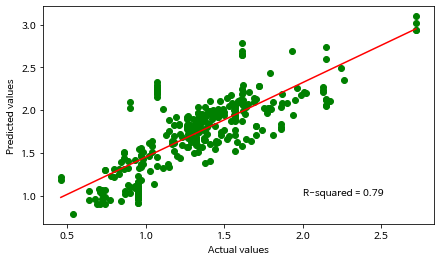

In [317]:
import scipy as sp
linreg = sp.stats.linregress(y_true, y_pred)
r2 = linreg.rvalue

plt.scatter(y_true,y_pred,color="green")
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

plt.plot(np.unique(y_true), np.poly1d(np.polyfit(y_true, y_pred, 1))(np.unique(y_true)),color="red")
plt.rcParams["figure.figsize"] = (7, 4)
plt.text(2,1,'R-squared = %0.2f' % r2)
plt.show()

## R2 분포 그리기

In [320]:
r2_list = []
for n in range(0,128):
    x_test = x_test2[n:(n+1)]
    y_test = y_test2[n:(n+1)]

    x_test_list = []
    y_test_list = []

    for i in range(0,y_test.shape[0]):
        for j in range(m,y_test.shape[1]-m):
            for k in range(m,y_test.shape[2]-m):
                y_test_list.append(y_test[i][j][k][0])    
                x_temp = x_test[i]
                x_temp = x_temp[(j-m):(j+m+1),(k-m):(k+m+1)]
                print(x_temp.shape)
                x_test_list.append(x_temp)        

    x_test_arr = np.array(x_test_list)
    y_test_arr = np.array(y_test_list)
    #cond = np.logical_wand((x_arr_sum != 0), (y_arr != 0))

    sub_x_test_arr = x_test_arr[y_test_arr != 0]
    sub_y_test_arr = y_test_arr[y_test_arr != 0]

    vidx = np.where(y_test_arr != 0)[0].tolist()

    from sklearn.metrics import mean_squared_error
    pred = model.predict(sub_x_test_arr)
    rmse = mean_squared_error(sub_y_test_arr, pred)**0.5

    mw = w - 2*m
    mh = h - 2*m

    result = np.zeros(len(y_test_arr))
    result[vidx] = pred.flatten()
    result = result.reshape([mw,mh])
    result_re = np.pad(result,3)

    y_test_re = y_test.flatten().reshape(w,h)

    # 파일 저장
    y_true = y_test_re.flatten()
    y_pred = result_re.flatten()

    y_true = y_true[y_pred != 0]
    y_pred = y_pred[y_pred != 0]
    linreg = sp.stats.linregress(y_true, y_pred)
    r2 = linreg.rvalue
    r2_list.append(r2)

(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)
(7, 7, 7)


In [322]:
r2_result = pd.DataFrame(r2_list)

In [324]:
r2_result.to_excel('./result/r2_result.xlsx')

/usr/local/lib/python3.6/dist-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '0.9.8' or newer of 'xlsxwriter' (version '0.7.3' currently installed).
  warnings.warn(msg, UserWarning)


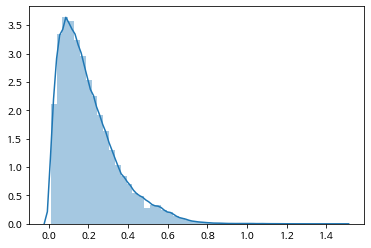

In [154]:
d = velocity_arr.flatten()
d = d[d!=0]
sns.distplot(d,bins=50, norm_hist=False, kde=True)

In [155]:
print(np.mean(d))
print(np.std(d))
print(np.min(d))
print(np.median(d))
print(np.max(d))

0.20043389082746924
0.14718777576240483
0.01
0.17
1.48


In [118]:
flat_list = [[cdom_result_arr.flatten(), chla_result_arr.flatten(),tss_result_arr.flatten(),
             vis_result_arr.flatten(),temp_arr.flatten(),salinity_arr.flatten(),
             waterlevel_arr.flatten(),velocity_arr.flatten()]]
flat_df = pd.DataFrame(flat_list)

In [120]:
cdom_result_arr

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

In [ ]:
sns.pairplot(flat_df)